In [1]:
import asf_search as asf
from shapely.geometry import Point, shape
from rasterio.crs import CRS
import geopandas as gpd
import pandas as pd
import contextily as cx
import matplotlib.pyplot as plt
from pathlib import Path
import requests
from tqdm import tqdm
import concurrent.futures

# Directory

In [2]:
out = Path('out')

# Search

In [3]:
resp = asf.geo_search(intersectsWith=Point(-99.8796, 16.8421).wkt,
                      processingLevel='RTC', 
                      platform=asf.constants.SENTINEL1)
len(resp)

6

The number should match this [search](https://search.asf.alaska.edu/#/?polygon=POINT(-99.8796%2016.8421)&zoom=9.133&center=-99.712,16.370&resultsLoaded=true&dataset=OPERA-S1&granule=OPERA_L2_RTC-S1_T078-165486-IW2_20231024T004829Z_20231024T091416Z_S1A_30_v1.0&productTypes=RTC).

In [4]:
properties = [r.properties for r in resp]
geometry = [shape(r.geojson()['geometry']) for r in resp]
properties_f = [{'opera_id': p['sceneName'], 
                 'start_time': p['startTime'],
                 'polarization': p['polarization'],
                 'url': p['url'], 
                 'track_number': p['pathNumber']} for p in properties]

df_resp = gpd.GeoDataFrame(properties_f, geometry=geometry, crs=CRS.from_epsg(4326))
df_resp.head()

,opera_id,start_time,polarization,url,track_number,geometry
0,OPERA_L2_RTC-S1_T078-165486-IW2_20231105T00482...,2023-11-05T00:48:29Z,VV,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,78,"POLYGON ((-99.92892 16.73507, -99.06057 16.896..."
1,OPERA_L2_RTC-S1_T041-086893-IW1_20231102T12352...,2023-11-02T12:35:27Z,VV,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,41,"POLYGON ((-99.50360 16.87667, -100.30172 17.02..."
2,OPERA_L2_RTC-S1_T078-165486-IW2_20231024T00482...,2023-10-24T00:48:29Z,VV,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,78,"POLYGON ((-99.92881 16.73528, -99.88313 16.743..."
3,OPERA_L2_RTC-S1_T041-086893-IW1_20231021T12352...,2023-10-21T12:35:27Z,VV,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,41,"POLYGON ((-99.50539 16.87704, -99.54850 16.885..."
4,OPERA_L2_RTC-S1_T078-165486-IW2_20231012T00482...,2023-10-12T00:48:28Z,VV,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,78,"POLYGON ((-99.92546 16.73504, -99.87977 16.743..."


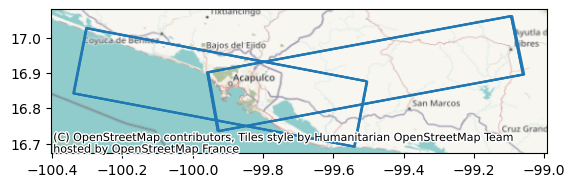

In [5]:
fig, ax = plt.subplots()
df_resp.exterior.plot(ax=ax)
cx.add_basemap(ax, crs=df_resp.crs.to_string())

## Update dataframe

See this issue: https://github.com/asfadmin/Discovery-asf_search/issues/231

In [6]:
df_resp['polarization'] = 'VH'
df_resp_vv = df_resp.copy()
df_resp_vv['polarization'] = 'VV'
df_resp_vv['url'] = df_resp_vv['url'].map(lambda url: url.replace('VH', 'VV'))
df = pd.concat([df_resp, df_resp_vv], axis=0).reset_index(drop=True)
df.head()

,opera_id,start_time,polarization,url,track_number,geometry
0,OPERA_L2_RTC-S1_T078-165486-IW2_20231105T00482...,2023-11-05T00:48:29Z,VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,78,"POLYGON ((-99.92892 16.73507, -99.06057 16.896..."
1,OPERA_L2_RTC-S1_T041-086893-IW1_20231102T12352...,2023-11-02T12:35:27Z,VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,41,"POLYGON ((-99.50360 16.87667, -100.30172 17.02..."
2,OPERA_L2_RTC-S1_T078-165486-IW2_20231024T00482...,2023-10-24T00:48:29Z,VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,78,"POLYGON ((-99.92881 16.73528, -99.88313 16.743..."
3,OPERA_L2_RTC-S1_T041-086893-IW1_20231021T12352...,2023-10-21T12:35:27Z,VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,41,"POLYGON ((-99.50539 16.87704, -99.54850 16.885..."
4,OPERA_L2_RTC-S1_T078-165486-IW2_20231012T00482...,2023-10-12T00:48:28Z,VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,78,"POLYGON ((-99.92546 16.73504, -99.87977 16.743..."


# Download

In [7]:
tracks = df.track_number.tolist()
opera_ids = df.opera_id.tolist()

out_paths = [out / Path(f'{t}/{oid}') for (t, oid) in zip(tracks, opera_ids)]
out_paths_unique = list(set(out_paths))
out_paths_unique

[PosixPath('out/78/OPERA_L2_RTC-S1_T078-165486-IW2_20231012T004828Z_20231012T162855Z_S1A_30_v1.0'),
 PosixPath('out/78/OPERA_L2_RTC-S1_T078-165486-IW2_20231105T004829Z_20231106T002602Z_S1A_30_v1.0'),
 PosixPath('out/41/OPERA_L2_RTC-S1_T041-086893-IW1_20231021T123527Z_20231022T093915Z_S1A_30_v1.0'),
 PosixPath('out/41/OPERA_L2_RTC-S1_T041-086893-IW1_20231102T123527Z_20231104T165644Z_S1A_30_v1.0'),
 PosixPath('out/41/OPERA_L2_RTC-S1_T041-086893-IW1_20231009T123527Z_20231010T052433Z_S1A_30_v1.0'),
 PosixPath('out/78/OPERA_L2_RTC-S1_T078-165486-IW2_20231024T004829Z_20231024T091416Z_S1A_30_v1.0')]

Make sure you have netrc with earthdata credentials.

In [8]:
def download_one_file(url: str, dest_dir: Path):
    """source: https://stackoverflow.com/questions/16694907/download-large-file-in-python-with-requests"""
    dest_dir.mkdir(exist_ok=True, parents=True)
    local_filename = url.split('/')[-1]
    out_path = dest_dir / local_filename
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(out_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                f.write(chunk)
    return out_path


def download_one_file_star(input_data):
    return download_one_file(*input_data)

In [9]:
zipped_inputs = list(zip(df.url.tolist(), out_paths))
zipped_inputs[0]

('https://datapool.asf.alaska.edu/RTC/OPERA-S1/OPERA_L2_RTC-S1_T078-165486-IW2_20231105T004829Z_20231106T002602Z_S1A_30_v1.0_VH.tif',
 PosixPath('out/78/OPERA_L2_RTC-S1_T078-165486-IW2_20231105T004829Z_20231106T002602Z_S1A_30_v1.0'))

In [10]:
# download_one_file_star(zipped_inputs[0])

In [11]:
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    out_paths = list(tqdm(executor.map(download_one_file_star, zipped_inputs[:]), total=len(zipped_inputs)))

100%|████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.94s/it]


# Serlialize Metadata

In [12]:
out_paths_str = list(map(str, out_paths))
df['local_path'] = out_paths_str

In [13]:
df.to_file(out / 'metadata.geojson', driver='GeoJSON')